# Detectron2 Detect Microcontrollers

<img src="doc/detection.png" width=300 height=300>

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Microcontroller-Detection-with-Detectron2/blob/master/Detectron2_Detect_Microcontrollers.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Microcontroller-Detection-with-Detectron2/blob/master/Detectron2_Detect_Microcontrollers.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [1]:
!pip install -U torch torchvision
!pip install git+https://github.com/facebookresearch/fvcore.git
import torch, torchvision
torch.__version__

Requirement already up-to-date: torch in /usr/local/lib/python3.6/dist-packages (1.3.1)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.6/dist-packages (0.4.2)
  Cloning https://github.com/facebookresearch/fvcore.git to /tmp/pip-req-build-u752d_cu
  Running command git clone -q https://github.com/facebookresearch/fvcore.git /tmp/pip-req-build-u752d_cu
     |████████████████████████████████| 266kB 7.1MB/s 
  Created wheel for fvcore: filename=fvcore-0.1-cp36-none-any.whl size=47549 sha256=90d30d92ed6becac871296b735d7088157ceea5e4be373d6b4d2164d40e6527a
  Stored in directory: /tmp/pip-ephem-wheel-cache-1ss7k9rg/wheels/48/53/79/3c6485543a4455a0006f5db590ab9957622b6227011941de06
  Created wheel for pyyaml: filename=PyYAML-5.1.2-cp36-cp36m-linux_x86_64.whl size=44104 sha256=297d1f174bb46d5d5221a3839be239a2bb20e58baada58fb8e9dfd49f25aaeb2
  Stored in directory: /root/.cache/pip/wheels/d9/45/dd/65f0b38450c47cf7e5312883deb97d065e030c5cca0a365030
Successfully built fvcore 

'1.3.1'

In [2]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 1452 (delta 23), reused 48 (delta 16), pack-reused 1376
Receiving objects: 100% (1452/1452), 1.67 MiB | 13.59 MiB/s, done.
Resolving deltas: 100% (857/857), done.
Obtaining file:///content/detectron2_repo
     |████████████████████████████████| 2.1MB 4.8MB/s 
     |████████████████████████████████| 61kB 11.1MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Running setup.py develop for detectron2


## Get data

In [0]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Before we can start training our model we need to download our data-set. In this case we will use my microcontroller detection data-set, which is [available on Kaggle](https://www.kaggle.com/tannergi/microcontroller-detection).

In [2]:
# Install Kaggle API
!pip install -q kaggle
!pip install -q kaggle-cli

     |████████████████████████████████| 81kB 4.3MB/s 
     |████████████████████████████████| 5.3MB 10.8MB/s 
     |████████████████████████████████| 112kB 77.7MB/s 
     |████████████████████████████████| 112kB 74.3MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 


If you are working in Colab you need to add the username and key contained in your kaggle.json file to your environment using os.

In [ ]:
# only for google colab
import os
os.environ['KAGGLE_USERNAME'] = "<username>" 
os.environ['KAGGLE_KEY'] = "<key>"

In [3]:
!kaggle datasets download -d tannergi/microcontroller-detection

 60% 5.00M/8.34M [00:00<00:00, 21.2MB/s]
100% 8.34M/8.34M [00:00<00:00, 33.1MB/s]


In [0]:
!unzip microcontroller-detection.zip

In [5]:
!ls

 detectron2_repo	      microcontroller-detection.zip
'Microcontroller Detection'   sample_data


In [2]:
import pandas as pd

df = pd.read_csv('Microcontroller Detection/train_labels.csv')

df.head()

filename  width  height  ... ymin  xmax  ymax
0  IMG_20181228_101826.jpg    800     600  ...  265   556   342
1  IMG_20181228_101855.jpg    800     600  ...  243   592   382
2  IMG_20181228_101903.jpg    800     600  ...  239   514   387
3  IMG_20181228_101915.jpg    800     600  ...  200   669   531
4  IMG_20181228_102013.jpg    800     600  ...  336   591   444

[5 rows x 8 columns]

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the [official documentation](https://detectron2.readthedocs.io/tutorials/datasets.html#register-a-dataset).

In [0]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_microcontroller_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['filename'].map(lambda x: img_dir+x)

    classes = ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora']

    df['class_int'] = df['class'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = height
        record["width"] = width

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [0]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = ['Raspberry_Pi_3', 'Arduino_Nano', 'ESP8266', 'Heltec_ESP32_Lora']

for d in ["train", "test"]:
  DatasetCatalog.register('microcontroller/' + d, lambda d=d: get_microcontroller_dicts('Microcontroller Detection/' + d + '_labels.csv', 'Microcontroller Detection/' + d+'/'))
  MetadataCatalog.get('microcontroller/' + d).set(thing_classes=classes)
microcontroller_metadata = MetadataCatalog.get('microcontroller/train')

We can check if our code works correctly by plotting a few images.

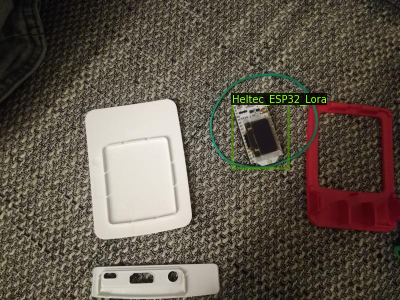

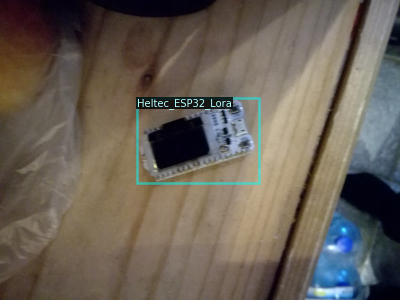

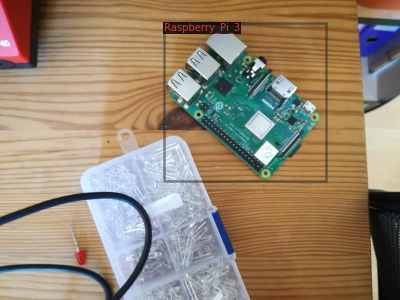

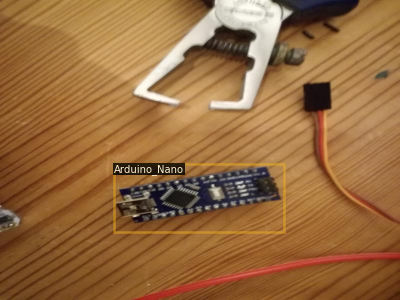

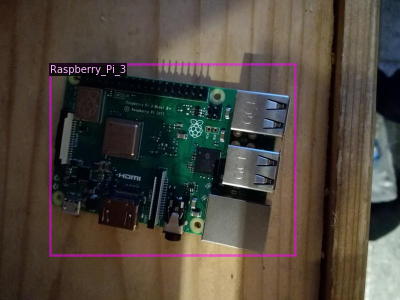

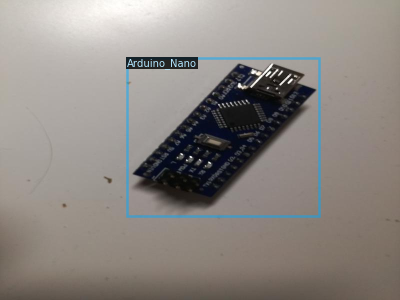

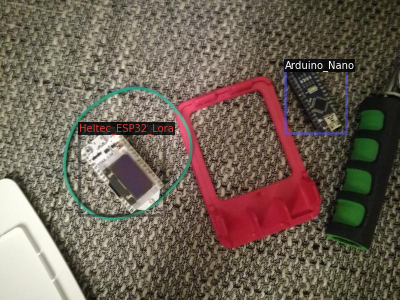

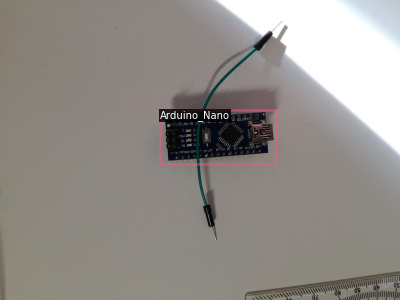

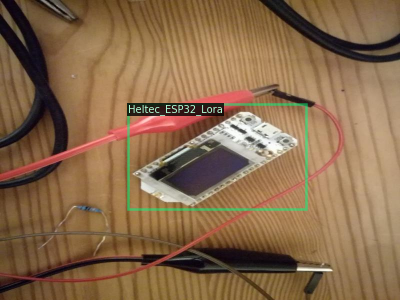

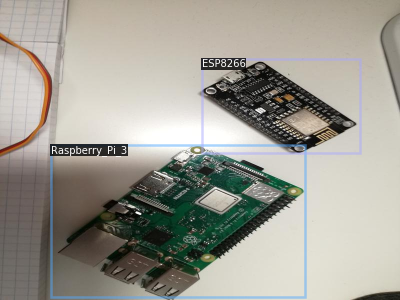

In [5]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = get_microcontroller_dicts('Microcontroller Detection/train_labels.csv', 'Microcontroller Detection/train/')
for d in random.sample(dataset_dicts, 10):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

## Train model

Now, let's fine-tune a pretrained FasterRCNN object detection model to detect the different microcontrollers.

In [6]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ('microcontroller/train',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [11/26 07:05:40 d2.config.compat]: Config './detectron2_repo/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.
[11/26 07:05:44 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (con

'roi_heads.box_predictor.cls_score.weight' has shape (81, 1024) in the checkpoint but (5, 1024) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (5,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 1024) in the checkpoint but (16, 1024) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (16,) in the model! Skipped.


[11/26 07:05:47 d2.engine.train_loop]: Starting training from iteration 0
[11/26 07:05:55 d2.utils.events]: eta: 0:06:20  iter: 19  total_loss: 1.164  loss_cls: 0.993  loss_box_reg: 0.149  loss_rpn_cls: 0.002  loss_rpn_loc: 0.003  time: 0.3896  data_time: 0.0026  lr: 0.000400  max_mem: 3208M
[11/26 07:06:03 d2.utils.events]: eta: 0:06:20  iter: 39  total_loss: 0.325  loss_cls: 0.173  loss_box_reg: 0.156  loss_rpn_cls: 0.002  loss_rpn_loc: 0.003  time: 0.3988  data_time: 0.0025  lr: 0.000799  max_mem: 3208M
[11/26 07:06:11 d2.utils.events]: eta: 0:06:11  iter: 59  total_loss: 0.312  loss_cls: 0.130  loss_box_reg: 0.175  loss_rpn_cls: 0.001  loss_rpn_loc: 0.002  time: 0.3976  data_time: 0.0027  lr: 0.001199  max_mem: 3208M
[11/26 07:06:19 d2.utils.events]: eta: 0:06:04  iter: 79  total_loss: 0.290  loss_cls: 0.118  loss_box_reg: 0.176  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3977  data_time: 0.0026  lr: 0.001598  max_mem: 3208M
[11/26 07:06:27 d2.utils.events]: eta: 0:05:58  it

OrderedDict()

In [8]:
# Download model if using Colab
from google.colab import files
path = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
files.download(path) 

----------------------------------------
Exception happened during processing of request from ('::ffff:127.0.0.1', 55328, 0, 0)
Traceback (most recent call last):
  File "/usr/lib/python3.6/socketserver.py", line 320, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 351, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.6/socketserver.py", line 364, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.6/socketserver.py", line 724, in __init__
    self.handle()
  File "/usr/lib/python3.6/http/server.py", line 418, in handle
    self.handle_one_request()
  File "/usr/lib/python3.6/http/server.py", line 406, in handle_one_request
    method()
  File "/usr/lib/python3.6/http/server.py", line 639, in do_GET
    self.copyfile(f, self.wfile)
  File "/usr/lib/python3.6/http/server.py", line 800, in copyfile
    shutil.copyfil

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ('microcontroller/test', )
predictor = DefaultPredictor(cfg)

In [10]:
df_test = pd.read_csv('Microcontroller Detection/test_labels.csv')
df_test

filename  width  height  ... ymin  xmax  ymax
0  IMG_20181228_102636.jpg    800     600  ...  205   465   313
1  IMG_20181228_102641.jpg    800     600  ...  251   553   405
2  IMG_20181228_102658.jpg    800     600  ...  130   618   330
3  IMG_20181228_102706.jpg    800     600  ...  137   640   472
4  IMG_20181228_102745.jpg    800     600  ...  135   609   366
5  IMG_20181228_102749.jpg    800     600  ...  179   540   372
6  IMG_20181228_102757.jpg    800     600  ...  215   658   443

[7 rows x 8 columns]

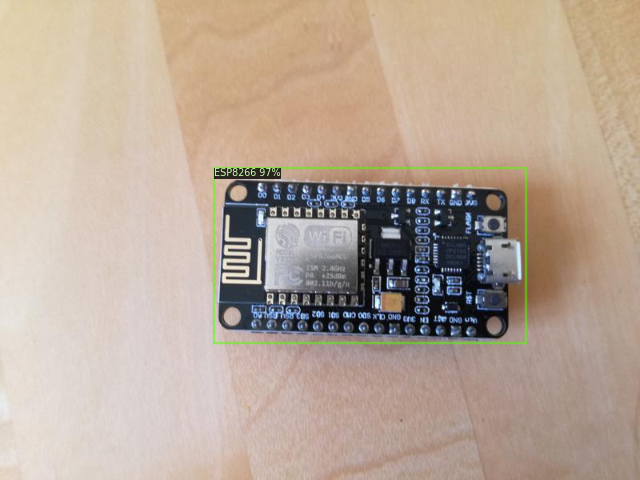

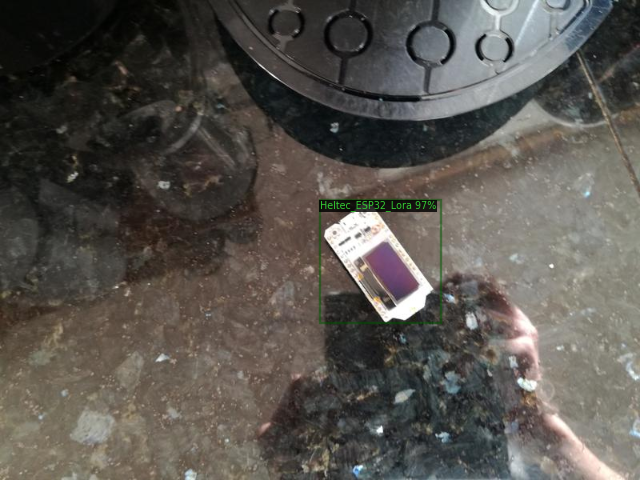

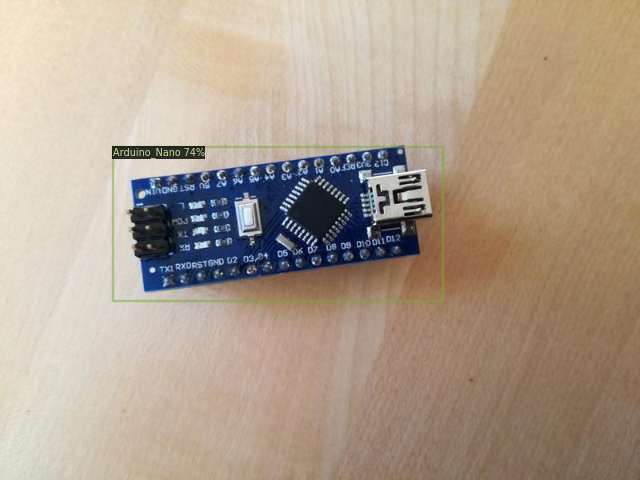

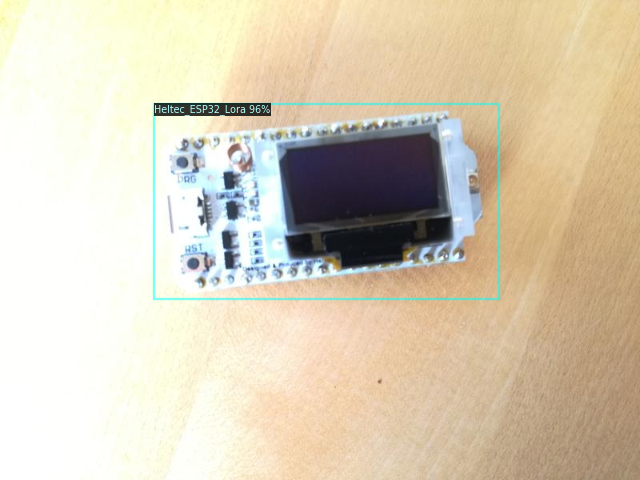

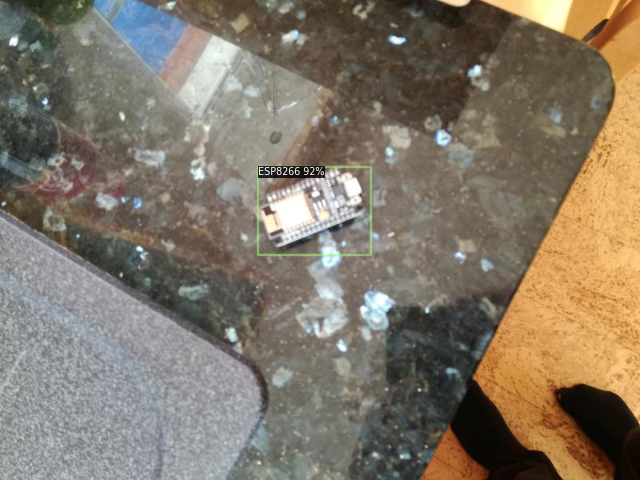

In [11]:
from detectron2.utils.visualizer import ColorMode
import random

dataset_dicts = get_microcontroller_dicts('Microcontroller Detection/test_labels.csv', 'Microcontroller Detection/test/')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=microcontroller_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output